# Initialized Vector Cloud: Eigenvector Cross-Sections

**Goal:** Visualize the extent of a *randomly initialized* embedding matrix when projected onto the trained model's eigenbasis.

**Hypothesis:** Random initialization produces isotropic vectors → when projected onto ANY basis (including the trained model's anisotropic eigenbasis), we should see roughly equal extents in all directions → "fuzzy cylinder" in cross-section.

**Method:**
1. Generate random embedding matrix (same shape as lm_head: 151,936 × 2,560)
2. Use Xavier/Kaiming initialization (small random values, variance scaled by dimensions)
3. Project these random vectors onto the **trained model's eigenbasis** (from causal metric M)
4. Compute cross-sectional extent along each eigenvector (in Euclidean distance units)
5. Compare to trained model (09.3b) to see what structure training added

**Expected result:** Approximately constant diameter across all eigenvector ranks (isotropic = no preferred directions).

## Configuration

In [10]:
# Data paths
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

# Matrix dimensions (match Qwen3-4B lm_head)
VOCAB_SIZE = 151936
HIDDEN_DIM = 2560

# Initialization parameters
INIT_METHOD = 'xavier_uniform'  # 'xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal'
RANDOM_SEED = 42  # For reproducibility

# Special eigenvectors to highlight (same as 09.3b for comparison)
SPECIAL_RANKS = {
}

print(f"Configuration:")
print(f"  Matrix shape: {VOCAB_SIZE:,} × {HIDDEN_DIM:,}")
print(f"  Initialization: {INIT_METHOD}")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Special eigenvectors: {list(SPECIAL_RANKS.keys())}")

Configuration:
  Matrix shape: 151,936 × 2,560
  Initialization: xavier_uniform
  Random seed: 42
  Special eigenvectors: []


## Setup

In [11]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")
print(f"✓ Random seed set: {RANDOM_SEED}")

✓ Imports complete
✓ Random seed set: 42


## Load Trained Model's Eigenbasis

In [12]:
print(f"Loading trained model's eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvectors = eigenbasis_data['eigenvectors']  # [hidden_dim, hidden_dim]
eigenvalues = eigenbasis_data['eigenvalues']    # [hidden_dim]

print(f"\n✓ Eigenbasis loaded")
print(f"  Eigenvectors shape: {eigenvectors.shape}")
print(f"  Eigenvalues shape: {eigenvalues.shape}")
print(f"  Eigenvalue range: [{eigenvalues.min():.2f}, {eigenvalues.max():.2f}]")

Loading trained model's eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...

✓ Eigenbasis loaded
  Eigenvectors shape: torch.Size([2560, 2560])
  Eigenvalues shape: torch.Size([2560])
  Eigenvalue range: [95.35, 94217.94]


## Generate Random Initialized Matrix

In [13]:
print(f"\nGenerating random initialized matrix ({VOCAB_SIZE:,} × {HIDDEN_DIM:,})...")
print(f"Using {INIT_METHOD} initialization...")

# Create a dummy linear layer to use PyTorch's initialization
dummy_layer = nn.Linear(HIDDEN_DIM, VOCAB_SIZE, bias=False)

# Apply initialization
if INIT_METHOD == 'xavier_uniform':
    nn.init.xavier_uniform_(dummy_layer.weight)
elif INIT_METHOD == 'xavier_normal':
    nn.init.xavier_normal_(dummy_layer.weight)
elif INIT_METHOD == 'kaiming_uniform':
    nn.init.kaiming_uniform_(dummy_layer.weight)
elif INIT_METHOD == 'kaiming_normal':
    nn.init.kaiming_normal_(dummy_layer.weight)
else:
    raise ValueError(f"Unknown initialization method: {INIT_METHOD}")

# Extract initialized weight matrix (transpose to match lm_head: [vocab, hidden])
gamma_init = dummy_layer.weight.data  # [vocab_size, hidden_dim]

print(f"\n✓ Random matrix generated")
print(f"  Shape: {gamma_init.shape}")
print(f"  Mean: {gamma_init.mean():.6f}")
print(f"  Std: {gamma_init.std():.6f}")
print(f"  Min: {gamma_init.min():.6f}")
print(f"  Max: {gamma_init.max():.6f}")

# Compute Euclidean norms
norms_init = torch.norm(gamma_init, dim=1)
print(f"\nEuclidean norms:")
print(f"  Mean: {norms_init.mean():.4f}")
print(f"  Std: {norms_init.std():.4f}")
print(f"  Range: [{norms_init.min():.4f}, {norms_init.max():.4f}]")
print(f"  CV: {(norms_init.std() / norms_init.mean() * 100):.2f}%")


Generating random initialized matrix (151,936 × 2,560)...
Using xavier_uniform initialization...

✓ Random matrix generated
  Shape: torch.Size([151936, 2560])
  Mean: 0.000000
  Std: 0.003598
  Min: -0.006232
  Max: 0.006232

Euclidean norms:
  Mean: 0.1820
  Std: 0.0016
  Range: [0.1750, 0.1900]
  CV: 0.89%


## Project Onto Trained Model's Eigenbasis

In [14]:
print("\nProjecting initialized vectors onto trained eigenbasis...")
print("This gives us projections in the trained model's principal component coordinates.")

# Project: gamma_init @ eigenvectors
# gamma_init: [vocab_size, hidden_dim]
# eigenvectors: [hidden_dim, hidden_dim] (columns are eigenvectors)
# Result: [vocab_size, hidden_dim] where each row is a token's projection onto eigenbasis

projections_init = gamma_init @ eigenvectors  # [vocab_size, hidden_dim]

print(f"\n✓ Projections computed")
print(f"  Shape: {projections_init.shape}")
print(f"  Mean: {projections_init.mean():.6f}")
print(f"  Std: {projections_init.std():.6f}")


Projecting initialized vectors onto trained eigenbasis...
This gives us projections in the trained model's principal component coordinates.

✓ Projections computed
  Shape: torch.Size([151936, 2560])
  Mean: 0.000000
  Std: 0.003598


## Compute Cloud Extent Along Each Eigenvector

In [15]:
print("\n" + "=" * 80)
print("COMPUTING CLOUD EXTENT ALONG ALL EIGENVECTORS")
print("=" * 80)

print(f"\nComputing extent for each of {HIDDEN_DIM:,} eigenvectors...")

# Convert to numpy
projections_np = projections_init.numpy()

# Compute max/min extent along each eigenvector (in EUCLIDEAN distance units)
# NOTE: Unlike 09.3b, we do NOT scale by sqrt(eigenvalue) because:
#   - These are initialized vectors in Euclidean space
#   - We're measuring Euclidean extent along basis directions
#   - The eigenbasis is just a convenient coordinate system, not a metric

max_extent = np.zeros(HIDDEN_DIM)
min_extent = np.zeros(HIDDEN_DIM)
diameters = np.zeros(HIDDEN_DIM)

for i in range(HIDDEN_DIM):
    # Projections in eigenbasis coordinates (Euclidean, no scaling)
    proj_i = projections_np[:, i]
    
    # Max and min extents
    max_extent[i] = proj_i.max()
    min_extent[i] = proj_i.min()
    diameters[i] = max_extent[i] - min_extent[i]

print(f"✓ Extents computed (in Euclidean distance units)\n")

# Summary statistics
print(f"Diameter statistics (Euclidean units):")
print(f"  Min: {diameters.min():.4f}")
print(f"  Max: {diameters.max():.4f}")
print(f"  Mean: {diameters.mean():.4f}")
print(f"  Median: {np.median(diameters):.4f}")
print(f"  Std: {diameters.std():.4f}")
print(f"  CV: {(diameters.std() / diameters.mean() * 100):.2f}%")

print(f"\nMax extent statistics:")
print(f"  Range: [{max_extent.min():.4f}, {max_extent.max():.4f}]")
print(f"  Mean: {max_extent.mean():.4f}")

print(f"\nMin extent statistics:")
print(f"  Range: [{min_extent.min():.4f}, {min_extent.max():.4f}]")
print(f"  Mean: {min_extent.mean():.4f}")


COMPUTING CLOUD EXTENT ALONG ALL EIGENVECTORS

Computing extent for each of 2,560 eigenvectors...
✓ Extents computed (in Euclidean distance units)

Diameter statistics (Euclidean units):
  Min: 0.0276
  Max: 0.0382
  Mean: 0.0322
  Median: 0.0320
  Std: 0.0014
  CV: 4.33%

Max extent statistics:
  Range: [0.0134, 0.0216]
  Mean: 0.0161

Min extent statistics:
  Range: [-0.0211, -0.0127]
  Mean: -0.0161


## Special Eigenvectors: Detailed View

In [16]:
print("\n" + "=" * 80)
print("SPECIAL EIGENVECTORS: EXTENT ANALYSIS")
print("=" * 80)

mean_diameter = diameters.mean()

print(f"\n{'Rank':<6} {'Eigenvalue':<15} {'Min':<10} {'Max':<10} {'Diameter':<12} {'vs. Mean':<12} {'Description'}")
print("=" * 100)

for rank in sorted(SPECIAL_RANKS.keys()):
    eigenval = eigenvalues[rank].item()
    min_ext = min_extent[rank]
    max_ext = max_extent[rank]
    diameter = diameters[rank]
    deviation = diameter - mean_diameter
    percent = (deviation / mean_diameter) * 100
    
    print(f"{rank:<6} {eigenval:>14,.0f} {min_ext:>9.4f} {max_ext:>9.4f} {diameter:>11.4f} {deviation:>+10.4f} ({percent:>+5.1f}%)  {SPECIAL_RANKS[rank]}")

print(f"\nMean diameter: {mean_diameter:.4f} Euclidean units")
print(f"\n**Interpretation:** Initialized vectors should show roughly equal diameter across all ranks.")
print(f"Small deviations are due to finite sampling (151k vectors).")


SPECIAL EIGENVECTORS: EXTENT ANALYSIS

Rank   Eigenvalue      Min        Max        Diameter     vs. Mean     Description

Mean diameter: 0.0322 Euclidean units

**Interpretation:** Initialized vectors should show roughly equal diameter across all ranks.
Small deviations are due to finite sampling (151k vectors).


## Cross-Sectional Envelope Plot


CREATING CROSS-SECTIONAL ENVELOPE PLOT


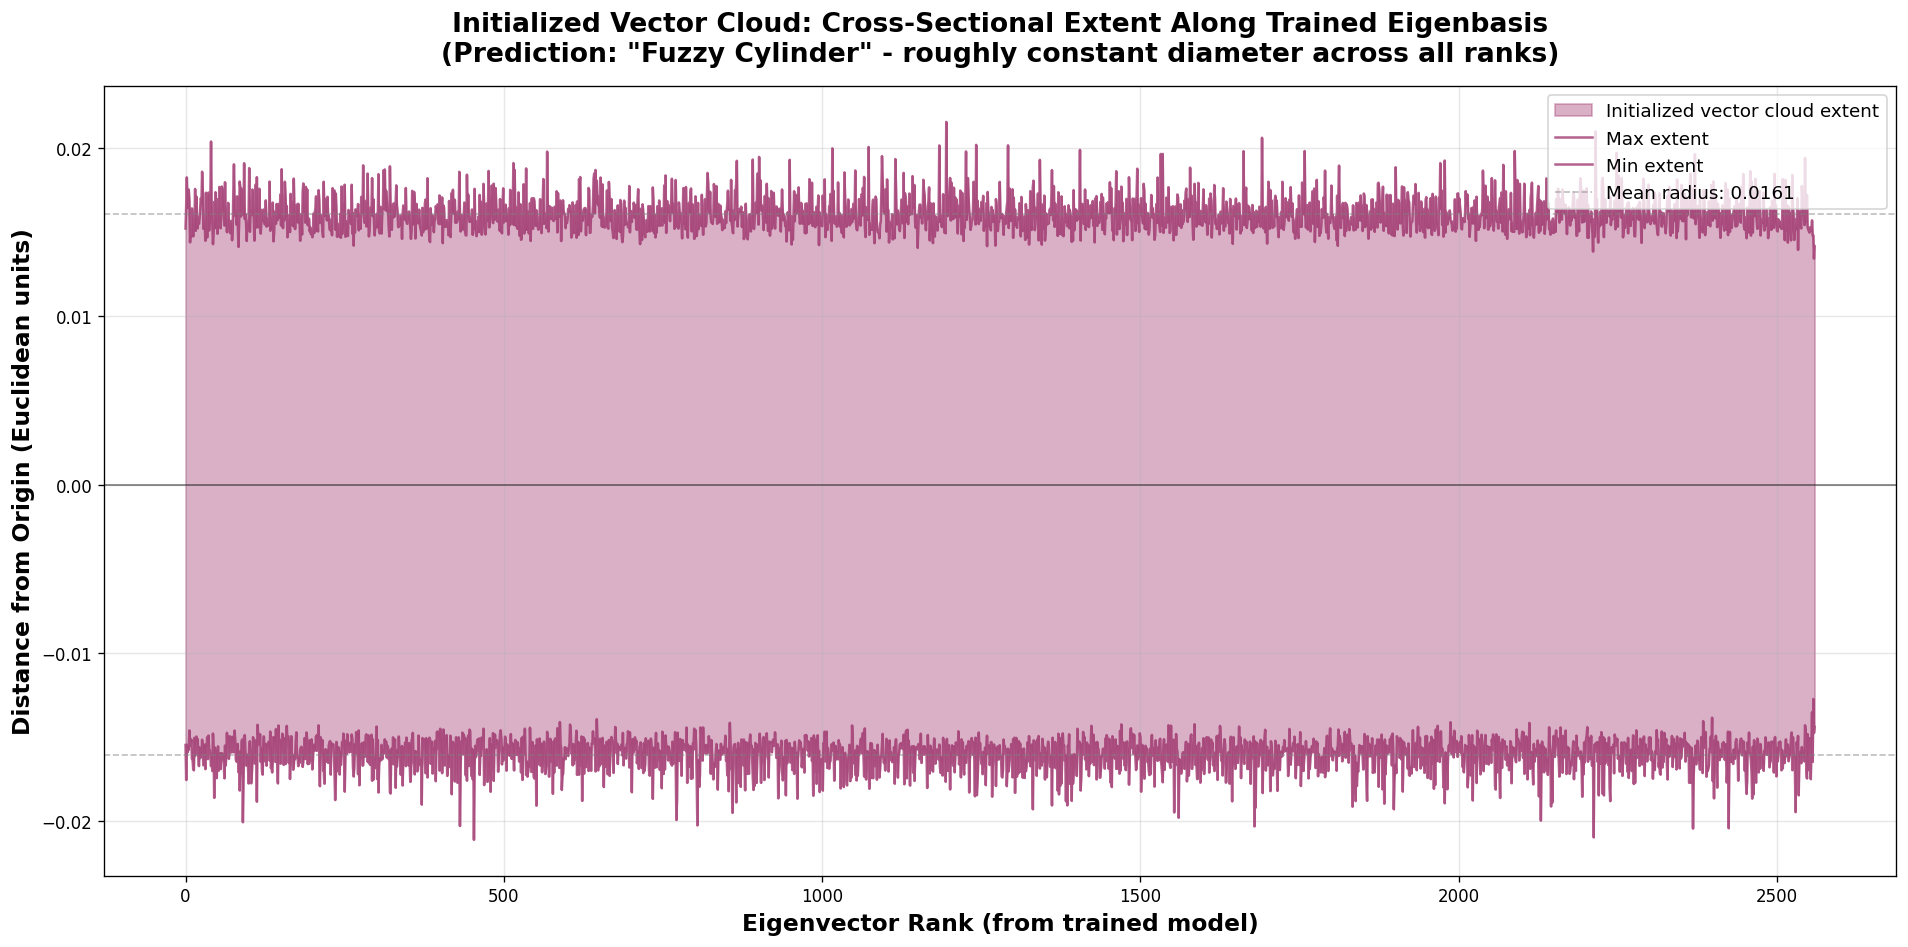


✓ Cross-sectional envelope plot created


In [17]:
print("\n" + "=" * 80)
print("CREATING CROSS-SECTIONAL ENVELOPE PLOT")
print("=" * 80)

# X-axis: eigenvector ranks
ranks = np.arange(HIDDEN_DIM)

# Create figure
fig, ax = plt.subplots(figsize=(16, 8), dpi=120)

# Plot envelope (shaded area between min and max)
ax.fill_between(ranks, min_extent, max_extent, 
                alpha=0.4, color='#A23B72', label='Initialized vector cloud extent')

# Plot upper and lower bounds
ax.plot(ranks, max_extent, linewidth=1.5, color='#A23B72', alpha=0.8, label='Max extent')
ax.plot(ranks, min_extent, linewidth=1.5, color='#A23B72', alpha=0.8, label='Min extent')

# Add zero line (origin)
ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add mean diameter line for reference
ax.axhline(mean_diameter/2, color='gray', linestyle='--', linewidth=1, alpha=0.5, 
           label=f'Mean radius: {mean_diameter/2:.4f}')
ax.axhline(-mean_diameter/2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Highlight special eigenvectors (for reference to trained model)
colors = {0: 'green', 2557: 'orange', 2558: 'red', 2559: 'purple'}
for rank in SPECIAL_RANKS.keys():
    ax.axvline(rank, color=colors[rank], linestyle='--', linewidth=1, alpha=0.3)

# Configure plot
ax.set_xlabel('Eigenvector Rank (from trained model)', fontsize=14, fontweight='bold')
ax.set_ylabel('Distance from Origin (Euclidean units)', fontsize=14, fontweight='bold')
ax.set_title('Initialized Vector Cloud: Cross-Sectional Extent Along Trained Eigenbasis\n(Prediction: "Fuzzy Cylinder" - roughly constant diameter across all ranks)',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Cross-sectional envelope plot created")

## Diameter Distribution Histogram


Creating diameter distribution histogram...


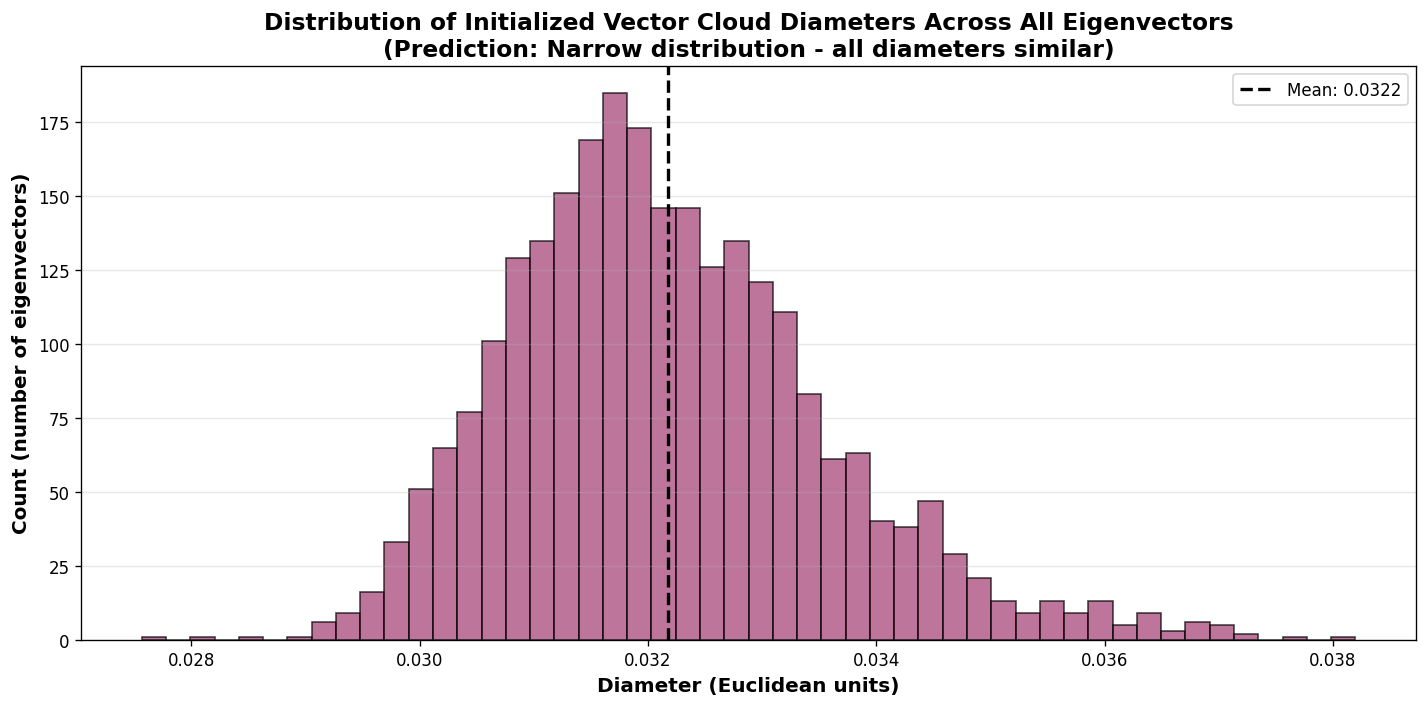

✓ Histogram created


In [18]:
print("\nCreating diameter distribution histogram...")

fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Histogram
counts, bins, patches = ax.hist(diameters, bins=50, color='#A23B72', alpha=0.7, edgecolor='black')

# Mark mean
ax.axvline(mean_diameter, color='black', linestyle='--', linewidth=2,
           label=f'Mean: {mean_diameter:.4f}')

# Mark special eigenvectors
for rank in SPECIAL_RANKS.keys():
    diameter = diameters[rank]
    ax.axvline(diameter, color=colors[rank], linestyle='-', linewidth=1.5,
               label=f'Rank {rank}: {diameter:.4f}', alpha=0.6)

ax.set_xlabel('Diameter (Euclidean units)', fontsize=12, fontweight='bold')
ax.set_ylabel('Count (number of eigenvectors)', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Initialized Vector Cloud Diameters Across All Eigenvectors\n(Prediction: Narrow distribution - all diameters similar)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Histogram created")

## Summary

**What we measured:** The extent of a randomly initialized embedding matrix when projected onto the trained model's eigenbasis.

**Key question:** Does random initialization produce isotropic vectors (equal extent in all directions)?

**Expected result:** "Fuzzy cylinder" - roughly constant diameter across all eigenvector ranks, with small variations due to finite sampling.

**Comparison to trained model (09.3b):**
- **Initialized (this notebook):** ~Constant diameter across ranks → isotropic, no structure
- **Trained (09.3b):** Dramatic variation in diameter → anisotropic, strong structure
  - Rank 0: Ø≈14.9 logometers (tokens cluster)
  - Ranks 2557-2559: Ø≈17-27 logometers (tokens stretched)
  - Most ranks: Ø≈11 logometers (baseline)

**Interpretation:** The difference between these plots shows what training *added* - the geometric structure that emerged from gradient descent.